In [ ]:

from datetime import datetime, timedelta, time
from functools import partial

import numpy as np
from dateutil import tz
from dateutil.relativedelta import relativedelta

import qprsim.config.modeling as mm
import qprsim.core.case as sc
import qprsim.shared.enums as enm
from qprsim.config import *
from qprsim.core import event_system as ev_sys
from qprsim.execution import SimulationContext, simulate, create_simulation_model, ExecutionParameters, ButWhatIf
from qprsim.model import graph_models as gm, visualize_sim_graph, sim_graph as sgraph
from qprsim.model.sim_graph import TransformationNode, SynchronizationNode, DelayNode
from qprsim.utils import utils, time_utils, viz, exporting

# @formatter:off
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2
# @formatter:on

In [2]:
log_name = 'washoku'
utils.ensure_path_exists(f'logs/{log_name}/')
utils.ensure_path_exists(f'models/{log_name}')
utils.ensure_path_exists('logging/')
timezone = tz.tzutc()  # tz.gettz('Asia/Tokyo')

In [3]:
builder = mm.ModelBuilder(use_defaults=False, skip_asserts=False)

In [4]:
prep_arrival = builder.add_arrival('prep')
customers_peak_arrival = builder.add_arrival('customers peak')
customers_arrival = builder.add_arrival('customers')

opening_arrival = builder.add_arrival('opening')
closing_arrival = builder.add_arrival('closing')

#builder.add_arrival('store')

terminal = builder.add_terminal('customers terminal')
builder.add_terminal('store terminal')
builder.add_terminal('prep terminal')

# resources
tenchou = builder.add_resource('Tenchou-san')
deshi_A = builder.add_resource('Deshi-san A')
deshi_B = builder.add_resource('Deshi-san B')
okusan = builder.add_resource('Oku-san')
baito_A = builder.add_resource('Baito-san A')
baito_B = builder.add_resource('Baito-san B')
customer = builder.add_resource('Customer-san')
tables = builder.add_resource('Restaurant Tables')
kitchen = builder.add_resource('Kitchen')
boh = [tenchou, deshi_A, deshi_B]
extended_boh = [tenchou, deshi_A, deshi_B, okusan]

foh = [okusan, baito_A, baito_B]
staff = [tenchou, deshi_A, deshi_B, okusan, baito_A, baito_B]

# entry & exit points

store_entrypoint = builder.add_tau('store entry', connect_to_arrival=[opening_arrival, closing_arrival])
prep_entrypoint = builder.add_tau('prep entry', connect_to_arrival=prep_arrival)
customers_entrypoint = builder.add_tau('customers entry',
                                       connect_to_arrival=[customers_arrival, customers_peak_arrival])
make_dish_entrypoint = builder.add_tau('make dish entry')

store_exitpoint = builder.add_tau('store exit', connect_to_terminal='store terminal')
prep_exitpoint = builder.add_tau('prep exit', connect_to_terminal='prep terminal')
customers_exitpoint = builder.add_tau('customers exit', connect_to_terminal='customers terminal')
make_dish_exitpoint = builder.add_tau('make dish exit')

# activities

## customers

customers_enter = builder.add_activity('Customer Group Enters', assignable_resources=[tables],
                                       resource_propensities={tables: 1})
customers_seated = builder.add_activity('Customer Group Occupies Table', assignable_resources=[tables],
                                        resource_propensities={tables: 10})
rec_order = builder.add_activity('Receive Order', assignable_resources=foh)
serve_order = builder.add_activity('Serve Table Order', assignable_resources=foh)
customer_eats = builder.add_activity('Customer Eats', assignable_resources=[customer])
customers_pay = builder.add_activity('Customer Group Pays', assignable_resources=[customer])
customers_exit = builder.add_activity('Customer Group Exits', assignable_resources=[customer])

## make dish

start_bowl = builder.add_activity('Get Bowl', assignable_resources=boh)
udon_to_pot = builder.add_activity('Add Udon to Pot', assignable_resources=boh)
udon_cooking = builder.add_aux_node('Udon is Cooking', DelayNode())
strain_udon = builder.add_activity('Strain and Wash Udon', assignable_resources=boh)
#reheat_udon = builder.add_activity('Reheat Udon', assignable_resources=[tenchou])
batter_tempura = builder.add_activity('Batter Tempura', assignable_resources=boh)
toss_tempura = builder.add_activity('Toss Tempura into Fryer', assignable_resources=boh)
tempura_frying = builder.add_aux_node('Tempura is Frying', DelayNode())
take_out_tempura = builder.add_activity('Take out Tempura', assignable_resources=boh)

dish_concurrency = builder.add_concurrency('assemble dish', number_of_splits=3)
dish_routing_base = builder.add_decision('dish routing base')
dish_routing_liquid = builder.add_decision('dish routing liquid')
dish_routing_topping = builder.add_decision('dish routing topping')

add_rice = builder.add_activity('Add Rice to Bowl', assignable_resources=extended_boh)
add_udon = builder.add_activity('Add Udon to Bowl', assignable_resources=boh)
add_dashi = builder.add_activity('Add Dashi to Bowl', assignable_resources=boh)
add_curry = builder.add_activity('Add Curry to Bowl', assignable_resources=boh)
add_tempura = builder.add_activity('Add Tempura to Bowl', assignable_resources=extended_boh)
add_scallions = builder.add_activity('Garnish Bowl with Scallions', assignable_resources=extended_boh)
#add_nori = builder.add_activity('Garnish Bowl with Nori', assignable_resources=boh)

## prep

misc_prep_prop = {tenchou: 0.5, deshi_A: 2, deshi_B: 2, okusan: 1}
prep_concurrency = builder.add_concurrency('prep concurrency', number_of_splits=5)
combine_dough = builder.add_activity('Combine Udon Dough', assignable_resources=boh)
mix_dough = builder.add_activity('Mix Udon Dough', assignable_resources=boh)
rest_dough = builder.add_activity('Rest Udon Dough', assignable_resources=[kitchen])
roll_dough = builder.add_activity('Roll Udon Dough', assignable_resources=boh)
cut_dough = builder.add_activity('Cut Udon Dough', assignable_resources=boh)

prep_curry = builder.add_activity('Prep Curry', assignable_resources=extended_boh,
                                  resource_propensities=misc_prep_prop)
prep_rice = builder.add_activity('Prep Rice', assignable_resources=extended_boh, resource_propensities=misc_prep_prop)
prep_tempura_ingredients = builder.add_activity('Prep Tempura Ingredients', assignable_resources=extended_boh,
                                                resource_propensities=misc_prep_prop)

combine_dashi_ingredients = builder.add_activity('Combine Dashi Ingredients', assignable_resources=boh)
boil_dashi = builder.add_activity('Boil Dashi', assignable_resources=[kitchen])
strain_dashi = builder.add_activity('Strain Dashi', assignable_resources=boh)

## store

store_routing = builder.add_decision('store routing')
store_args = {'assignable_resources': staff,
              'resource_propensities': {tenchou: 0.5, deshi_A: 1, deshi_B: 1, okusan: 5, baito_A: 5, baito_B: 5}}
open_store = builder.add_activity('Open Store', **store_args)
setup_store = builder.add_activity('Setup Store', **store_args)
open_store_business = builder.add_activity('Open for Business', **store_args)
close_store_business = builder.add_activity('Close for Business', **store_args)
cleanup_store = builder.add_activity('Cleanup Store', **store_args)
close_store = builder.add_activity('Close Store', **store_args)

### Make dish subprocess

In [5]:
make_dish_delay = builder.add_aux_node('make dish callout', DelayNode())

builder.connect(make_dish_entrypoint, make_dish_delay)
builder.connect(make_dish_delay, start_bowl)
builder.connect(start_bowl, mm.split_of(dish_concurrency))


def split_off_tempura(case: sc.Case):
    res = [(case, {'successor_id': 0})]
    if 'tempura' in case.get_case_attr_value('dish'):
        res.append((case, {'successor_id': 1}))
    return res


fry_if_necessary = builder.add_aux_node('fry if necessary', TransformationNode())
builder.set_aux_config(fry_if_necessary, arbitraryMHC(gm.CaseTransformerModel, transformer=split_off_tempura))

builder.connect_as_concurrency(dish_concurrency, [dish_routing_base, dish_routing_liquid, fry_if_necessary])

builder.connect(fry_if_necessary, batter_tempura)
builder.connect(batter_tempura, toss_tempura)
builder.connect(toss_tempura, tempura_frying)
builder.connect(tempura_frying, take_out_tempura)
tempura_sync = builder.add_aux_node('tempura synchronizer', SynchronizationNode())
builder.set_aux_config(tempura_sync, arbitraryMHC(gm.SimpleCountSyncModel, expected_count=2))
builder.connect(take_out_tempura, tempura_sync)
builder.connect(tempura_sync, add_tempura)

builder.connect(udon_to_pot, udon_cooking)
builder.connect(udon_cooking, strain_udon)
builder.connect(strain_udon, add_udon)

builder.connect_as_decision(dish_routing_base, [(udon_to_pot, add_udon), add_rice])
builder.connect_as_decision(dish_routing_liquid, [add_dashi, add_curry])
builder.connect_as_decision(dish_routing_topping, [(tempura_sync, add_tempura)], add_skip_at_idx=0)

builder.connect(mm.join_of(dish_concurrency), mm.split_of(dish_routing_topping))
builder.connect(mm.join_of(dish_routing_topping), add_scallions)
builder.connect(add_scallions, make_dish_exitpoint)

In [6]:
builder.set_config(dish_routing_base,
                   DecisionConfig(
                       config.AttributeBasedClassifier('dish', lambda dish: 0 if 'udon' in dish else 1,
                                                       config.AttributeLevel.Case)))
builder.set_config(dish_routing_liquid,
                   DecisionConfig(
                       config.AttributeBasedClassifier('dish',
                                                       lambda dish: 0 if 'udon' in dish and 'karee' not in dish else 1,
                                                       config.AttributeLevel.Case)))
builder.set_config(dish_routing_topping,
                   DecisionConfig(
                       config.AttributeBasedClassifier('dish', lambda dish: 1 if 'tempura' in dish else 0,
                                                       config.AttributeLevel.Case)))

### Customers Process

In [7]:
builder.connect(customers_entrypoint, customers_enter)

#kitchen_open_decision = builder.add_decision('kitchen still open')
#builder.connect(customers_enter, kitchen_open_decision)

customer_concurrency = builder.add_concurrency('customer concurrency')

customers_seated_syncer = builder.add_aux_node('customers syncer', SynchronizationNode())

customers_finished_signaler = builder.add_aux_node('customers signaler', SynchronizationNode())

builder.connect(customers_enter, customer_concurrency)

order_loop = builder.add_decision('order loop')
builder.connect_as_concurrency(customer_concurrency,
                               [customers_seated, (customers_seated_syncer, customers_finished_signaler)])

builder.connect(customers_seated_syncer, mm.join_of(order_loop))
make_dishes_split = builder.add_aux_node('make dishes split', TransformationNode())
builder.connect_as_loop(order_loop, do=rec_order, escape=make_dishes_split)

order_sync = builder.add_aux_node('order sync', SynchronizationNode())
builder.connect(make_dishes_split, [order_sync, make_dish_entrypoint])
builder.connect(make_dish_exitpoint, order_sync)

builder.connect(order_sync, serve_order)
eat_dishes_split = builder.add_aux_node('eat dishes split', TransformationNode())
eating_sync = builder.add_aux_node('eating sync', SynchronizationNode())
builder.connect(serve_order, eat_dishes_split)
builder.connect(eat_dishes_split, [eating_sync, customer_eats])
builder.connect(customer_eats, eating_sync)
builder.connect(eating_sync, customers_pay)
builder.connect(customers_pay, customers_finished_signaler)

builder.connect(customer_concurrency, customers_exit)
builder.connect(customers_exit, customers_exitpoint)

In [8]:
builder.set_config(order_loop, DecisionConfig(
    config.LambdaClassifier.binary(
        lambda case: case.get_latest_event_attr_value('order_no') >= case.get_case_attr_value('customer_count'))))

### Prep Process

In [9]:
builder.connect(prep_entrypoint, prep_concurrency)

builder.connect_as_concurrency(prep_concurrency,
                               [(combine_dashi_ingredients, strain_dashi), (combine_dough, cut_dough), prep_rice,
                                prep_curry, prep_tempura_ingredients])
builder.connect(combine_dashi_ingredients, boil_dashi)
builder.connect(boil_dashi, strain_dashi)
builder.connect(combine_dough, mix_dough)
builder.connect(mix_dough, rest_dough)
builder.connect(rest_dough, roll_dough)
builder.connect(roll_dough, cut_dough)

builder.connect(prep_concurrency, prep_exitpoint)

### Store Process

In [10]:
builder.connect(store_entrypoint, store_routing)
builder.connect_as_decision(store_routing,
                            [(open_store, open_store_business), (close_store_business, cleanup_store, close_store)])
builder.connect(open_store, setup_store)
builder.connect(setup_store, open_store_business)
builder.connect(close_store_business, cleanup_store)
builder.connect(cleanup_store, close_store)
builder.connect([open_store_business, close_store], store_exitpoint)

In [11]:
builder.set_config(store_routing, DecisionConfig(
    config.AttributeBasedClassifier.fixed_values('description', ['open', 'close'], sc.AttributeLevel.Case)))

### Subprocess Synchronization

In [12]:
def get_global_id(case, no):
    cgid = case.get_case_attr_value('customer_group_id')
    goid = f'{cgid}_{no}'
    return goid

In [13]:
def split_off_dishes(case: sc.Case):
    res = [(case, {'successor_id': 0})]
    for ce in case.filter(lambda ce: 'dish' in ce.attributes):
        dish = ce.attributes['dish']
        no = ce.attributes['order_no']
        child = sc.create_child(case, sub_id=str(no), dish=dish, order_no=no, global_order_id=get_global_id(case, no))
        res.append((child, {'successor_id': 1}))
    return res

In [14]:
builder.set_aux_config(make_dishes_split, arbitraryMHC(gm.CaseTransformerModel, transformer=split_off_dishes))
builder.set_aux_config(eat_dishes_split, arbitraryMHC(gm.CaseTransformerModel, transformer=split_off_dishes))

In [15]:
sync_config = arbitraryMHC(gm.AwaitChildrenSync,
                           calc_expectation=lambda case: case.get_case_attr_value('customer_count'))
builder.set_aux_config(order_sync, sync_config)
builder.set_aux_config(eating_sync, sync_config)

### Config

In [16]:
business_days = {enm.Weekdays.Tuesday, enm.Weekdays.Wednesday, enm.Weekdays.Thursday, enm.Weekdays.Friday,
                 enm.Weekdays.Saturday, enm.Weekdays.Sunday}

customers_arrival_bh = config.ExtendedBusinessHours.fixed_times([(time(11, 20), time(14)), (time(17, 40), time(20))],
                                                                business_days)
customers_peak_arrival_bh = config.ExtendedBusinessHours.fixed_times(
    [(time(13), time(13, 15)), (time(18, 30), time(19))],
    business_days & time_utils.Workweek)
business_hours = config.ExtendedBusinessHours.fixed_times([(time(11, 30), time(14, 30)), (time(18), time(21))],
                                                          business_days)
kitchen_hours = config.ExtendedBusinessHours.fixed_times([(time(11, 30), time(14, 15)), (time(18), time(20, 45))],
                                                         business_days)

tenchou_hours = config.WorkweekBusinessHours.fixed_time((time(6), time(23, 59)), business_days)
deshi_hours = config.WorkweekBusinessHours.fixed_time((time(9), time(21)), business_days)
baito_hours = config.ExtendedBusinessHours.fixed_times([(time(10, 30), time(15)), (time(17), time(21))], business_days)

### Activity Config

In [17]:
dishes_freqs = [0.3, 0.45, 0.1, 0.15]
dishes = ['karee udon', 'tempura udon', 'tempura rice', 'karee rice']
prices = {'karee udon': 770, 'tempura udon': 1000, 'tempura rice': 850, 'karee rice': 500}

In [18]:
class ExObj:

    def __init__(self) -> None:
        super().__init__()
        self.pos_handler = None
        self.neg_handler = None
        self.callbacks = {}

    def register_callback(self, callback, case: sc.Case, resource):
        self.callbacks[case.case_id] = callback
        self.pos_handler(case)

    def register_discarded(self, case: sc.Case):
        self.neg_handler(case)
        print(f'case {case} was sadly discarded unfairly')


ex = ExObj()


class Syncer(gm.SyncModel):

    def __init__(self, exobj: ExObj, event_queue: ev_sys.EventQueue, simulation_context: SimulationContext,
                 **kwargs) -> None:
        super().__init__(**kwargs)
        self.event_queue: ev_sys.EventQueue = event_queue
        self.sc: SimulationContext = simulation_context
        self.exobj = exobj
        self.exobj.pos_handler = self.pos
        self.exobj.neg_handler = self.neg
        self.blacklist = set()
        self.whitelist = set()

    def pos(self, case):
        c = self.waiting_on_sync.pop(case.case_id, None)
        if c is not None:
            self.forward(case)
            #self.event_queue.offer_immediate(ev_sys.Callback(self.forward, case))
        else:
            self.whitelist.add(case.case_id)

    def neg(self, case):
        c = self.waiting_on_sync.pop(case.case_id, None)
        if c is None:
            self.blacklist.add(case.case_id)
            self.sc.register_case_abortion(case)

    def _check_sync_possibility(self, newcomer: sc.Case) -> gm.SyncResult:
        if newcomer.case_id in self.blacklist:
            self.blacklist.remove(newcomer.case_id)
            return gm.SyncResult.skip()
        elif newcomer.case_id in self.whitelist:
            self.whitelist.remove(newcomer.case_id)
            return gm.SyncResult.wave_through(newcomer)
        else:
            return gm.SyncResult.enqueue(newcomer)


class Signaler(gm.SyncModel):

    def __init__(self, exobj: ExObj, node: sgraph.WithModel = None, **kwargs) -> None:
        super().__init__(node, **kwargs)
        self.exobj = exobj

    def _check_sync_possibility(self, newcomer: sc.Case) -> gm.SyncResult:
        cb = self.exobj.callbacks.pop(newcomer.case_id)
        cb.activate()
        return gm.SyncResult.wave_through(newcomer)


builder.set_config(customers_enter,
                   ActivityConfig(config.Fifo, config.ExpSampler(1), business_hours=business_hours, property_dict={
                       enm.ActivityProperty.MaxQueueLength: 5}))
builder.set_aux_config(customers_seated_syncer, arbitraryMHC(Syncer, requires_unsafe_access=True, exobj=ex))
builder.set_aux_config(customers_finished_signaler, arbitraryMHC(Signaler, exobj=ex))
builder.set_config(customers_seated, ActivityConfig(config.Fifo, config.StaticSampler(timedelta(minutes=30)),
                                                    business_hours=kitchen_hours,
                                                    property_dict={enm.ActivityProperty.MaxQueueLength: 5,
                                                                   enm.ActivityProperty.DiscardIfNotInBusiness: True,
                                                                   enm.ActivityProperty.ExternalDiscardingHandler: ex.register_discarded,
                                                                   enm.ActivityProperty.ExternalProcessingHandler: ex.register_callback}))


def inc_orders(case: sc.Case, *args, **kwargs):
    return {'order_no': (case.get_latest_event_attr_value('order_no') or 0) + 1,
            'global_order_id': get_global_id(case, (case.get_latest_event_attr_value("order_no") or 0) + 1)}


dish_attr_gen = config.ActivityAttributeGenerator(
    complete=config.AttributeGeneratorUnion(config.LambdaAttributeGenerator(inc_orders),
                                            config.StochasticAttributeGenerator.from_lists(dishes_freqs, [
                                                config.StaticAttributeGenerator(dish=d) for d in dishes])))

builder.set_config(rec_order, ActivityConfig(config.Fifo,
                                             config.ExpSampler(1),
                                             attribute_generator=dish_attr_gen))


def calc_order_total(case: sc.Case, *args, **kwargs):
    total = sum(
        prices[dish] for dish in
        case.project(lambda e: (e.activity == rec_order) and ('dish' in e.attributes), lambda e: e.attributes['dish']))
    return {'amount': total}


builder.set_config(serve_order, ActivityConfig(config.Fifo, config.ExpSampler(1)))
builder.set_config(customer_eats, ActivityConfig(config.Fifo, config.NormSampler(10, scale=4)))
builder.set_config(customers_pay,
                   ActivityConfig(config.Fifo, config.ExpSampler(1),
                                  attribute_generator=config.ActivityAttributeGenerator(
                                      complete=config.LambdaAttributeGenerator(calc_order_total))))
builder.set_config(customers_exit, ActivityConfig(config.Fifo, config.ZeroSampler))

In [19]:
builder.set_config(combine_dashi_ingredients, ActivityConfig(config.Fifo,
                                                             config.NormSampler(20, scale=2)))
builder.set_config(boil_dashi, ActivityConfig(config.Fifo,
                                              config.StaticSampler(timedelta(hours=1, minutes=30))))
builder.set_config(strain_dashi, ActivityConfig(config.Fifo,
                                                config.NormSampler(10, scale=2)))

builder.set_config(combine_dough, ActivityConfig(config.Fifo, config.NormSampler(10, scale=2)))
builder.set_config(mix_dough, ActivityConfig(config.Fifo, config.NormSampler(10, scale=2)))
builder.set_config(rest_dough, ActivityConfig(config.Fifo, config.StaticSampler(timedelta(hours=3))))
builder.set_config(roll_dough, ActivityConfig(config.Fifo, config.NormSampler(30, scale=2)))
builder.set_config(cut_dough, ActivityConfig(config.Fifo, config.NormSampler(10, scale=2)))

builder.set_config(prep_curry, ActivityConfig(config.Fifo,
                                              config.NormSampler(60, scale=2)))
builder.set_config(prep_rice, ActivityConfig(config.Fifo,
                                             config.NormSampler(30, scale=2)))
builder.set_config(prep_tempura_ingredients, ActivityConfig(config.Fifo,
                                                            config.NormSampler(120, scale=10)))

In [20]:
minimal_task = ActivityConfig(config.Fifo, config.ExpSampler(1))
builder.set_config(open_store, minimal_task)
builder.set_config(setup_store, ActivityConfig(config.Fifo,
                                               config.NormSampler(20, scale=2)))
builder.set_config(open_store_business, minimal_task)
builder.set_config(close_store_business, minimal_task)
builder.set_config(cleanup_store, ActivityConfig(config.Fifo,
                                                 config.NormSampler(20, scale=2)))
builder.set_config(close_store, minimal_task)

In [21]:
skill_issue = {tenchou: 2, deshi_A: 1, deshi_B: 1, okusan: 0.75, baito_A: 0.5, baito_B: 0.5}
short_task_sampler = config.ResourceDependentPTSampler(config.NormSampler(30, scale=8, unit='s'), skill_issue,
                                                       use_resource_performance=True)
minimal_task_sampler = config.ResourceDependentPTSampler(config.NormSampler(15, scale=4, unit='s'), skill_issue,
                                                         use_resource_performance=True)

builder.set_aux_config(make_dish_delay, DelayConfig(config.NormSampler(30, scale=2, unit='s')))


def track_orders(case: sc.Case, *args, **kwargs):
    return {'global_order_id': case.get_case_attr_value('global_order_id')}


bowl_attribute_copy = config.ActivityAttributeGenerator(start=config.LambdaAttributeGenerator(track_orders),
                                                        complete=config.LambdaAttributeGenerator(track_orders))

builder.set_config(start_bowl,
                   ActivityConfig(config.Fifo, minimal_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_config(udon_to_pot,
                   ActivityConfig(config.Fifo, minimal_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_aux_config(udon_cooking, DelayConfig(config.StaticSampler(timedelta(minutes=3))))
builder.set_config(strain_udon,
                   ActivityConfig(config.Fifo, short_task_sampler, attribute_generator=bowl_attribute_copy))

builder.set_config(batter_tempura,
                   ActivityConfig(config.Fifo, minimal_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_config(toss_tempura,
                   ActivityConfig(config.Fifo, minimal_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_aux_config(tempura_frying, DelayConfig(config.StaticSampler(timedelta(minutes=4))))
builder.set_config(take_out_tempura,
                   ActivityConfig(config.Fifo, short_task_sampler, attribute_generator=bowl_attribute_copy))

builder.set_config(add_udon, ActivityConfig(config.Fifo, short_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_config(add_rice, ActivityConfig(config.Fifo, short_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_config(add_dashi, ActivityConfig(config.Fifo, short_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_config(add_curry, ActivityConfig(config.Fifo, short_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_config(add_tempura,
                   ActivityConfig(config.Fifo, short_task_sampler, attribute_generator=bowl_attribute_copy))
builder.set_config(add_scallions,
                   ActivityConfig(config.Fifo, minimal_task_sampler, attribute_generator=bowl_attribute_copy))

### Resource Config

In [22]:
builder.set_config(customer, ResourceConfig(np.inf))
builder.set_config(kitchen, ResourceConfig(np.inf))
initial_table_count = 15
builder.set_config(tables, ResourceConfig(initial_table_count, business_hours))

builder.set_config(tenchou, ResourceConfig(2, tenchou_hours, config.PeakPerformance))
builder.set_config(okusan, ResourceConfig(1, tenchou_hours, config.PeakPerformance))
builder.set_config(deshi_A, ResourceConfig(1, deshi_hours, config.PeakPerformance))
builder.set_config(deshi_B, ResourceConfig(1, deshi_hours, config.PeakPerformance))
builder.set_config(baito_A, ResourceConfig(1, baito_hours, config.PeakPerformance))
builder.set_config(baito_B, ResourceConfig(1, baito_hours, config.PeakPerformance))

### Arrivals Config

In [23]:
process_start = datetime(2023, 4, 1, tzinfo=timezone)
generation_end = datetime(2024, 3, 31, 23, 59, tzinfo=timezone)

In [24]:
def get_customer_group_id(proposed_case_id):
    res = str.removeprefix(proposed_case_id, 'customers')
    if res.startswith('_'):
        res = 'regular' + res
    return res


customers_id_gen = config.LambdaAttributeGenerator(
    lambda proposed_case_id, *args, **kwargs: {'case_type': 'customers',
                                               'customer_group_id': get_customer_group_id(proposed_case_id)})

initial_customer_arrival_cfg = ArrivalProcessConfig(process_start, config.ExpSampler(9), customers_arrival_bh,
                                                    attribute_generator=config.AttributeGeneratorUnion(customers_id_gen,
                                                                                                       config.StaticAttributeGenerator(
                                                                                                           customer_count=partial(
                                                                                                               np.random.randint,
                                                                                                               1, 4))))
initial_customer_peak_arrival_cfg = ArrivalProcessConfig(process_start, config.ExpSampler(2), customers_peak_arrival_bh,
                                                         attribute_generator=config.AttributeGeneratorUnion(
                                                             customers_id_gen,
                                                             config.StaticAttributeGenerator(
                                                                 customer_count=1)))
builder.set_arrival_configs({customers_arrival: initial_customer_arrival_cfg,
                             customers_peak_arrival: initial_customer_peak_arrival_cfg,
                             prep_arrival: ArrivalProcessConfig(process_start, config.EpsilonSampler,
                                                                config.WorkweekBusinessHours.fixed_time(
                                                                    time_utils.epsilon_tuple(time(hour=5)),
                                                                    business_days),
                                                                attribute_generator=config.StaticAttributeGenerator(
                                                                    case_type='prep')),
                             opening_arrival: ArrivalProcessConfig(process_start,
                                                                   config.EpsilonSampler,
                                                                   config.ExtendedBusinessHours.fixed_times(
                                                                       [time_utils.epsilon_tuple(time(hour=11)),
                                                                        time_utils.epsilon_tuple(
                                                                            time(hour=17, minute=30))],
                                                                       business_days),
                                                                   attribute_generator=config.StaticAttributeGenerator(
                                                                       case_type='store', description='open')),
                             closing_arrival: ArrivalProcessConfig(process_start,
                                                                   config.EpsilonSampler,
                                                                   config.ExtendedBusinessHours.fixed_times(
                                                                       [time_utils.epsilon_tuple(
                                                                           time(hour=14, minute=30)),
                                                                           time_utils.epsilon_tuple(time(hour=21))],
                                                                       business_days),
                                                                   attribute_generator=pi.StaticAttributeGenerator(
                                                                       case_type='store', description='close'))})

In [25]:
builder.fill_defaults()

In [26]:
sg, cfg = builder.build()

In [27]:
sg.aux_model_haver_map

{'Udon is Cooking': <qprsim.model.sim_graph.DelayNode at 0x25bd7c87a90>,
 'Tempura is Frying': <qprsim.model.sim_graph.DelayNode at 0x25bb1cc1c90>,
 'make dish callout': <qprsim.model.sim_graph.DelayNode at 0x25bb1d1bb90>,
 'fry if necessary': <qprsim.model.sim_graph.TransformationNode at 0x25bb1d1b690>,
 'tempura synchronizer': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1b58050>,
 'customers syncer': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d24150>,
 'customers signaler': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d23a10>,
 'make dishes split': <qprsim.model.sim_graph.TransformationNode at 0x25bb1d23b90>,
 'order sync': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d23cd0>,
 'eat dishes split': <qprsim.model.sim_graph.TransformationNode at 0x25bb1d23ed0>,
 'eating sync': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d21e10>,
 'dish routing base': <qprsim.model.sim_graph.XorSplit at 0x25bb19ee710>,
 'dish routing liquid': <qprsim.model.

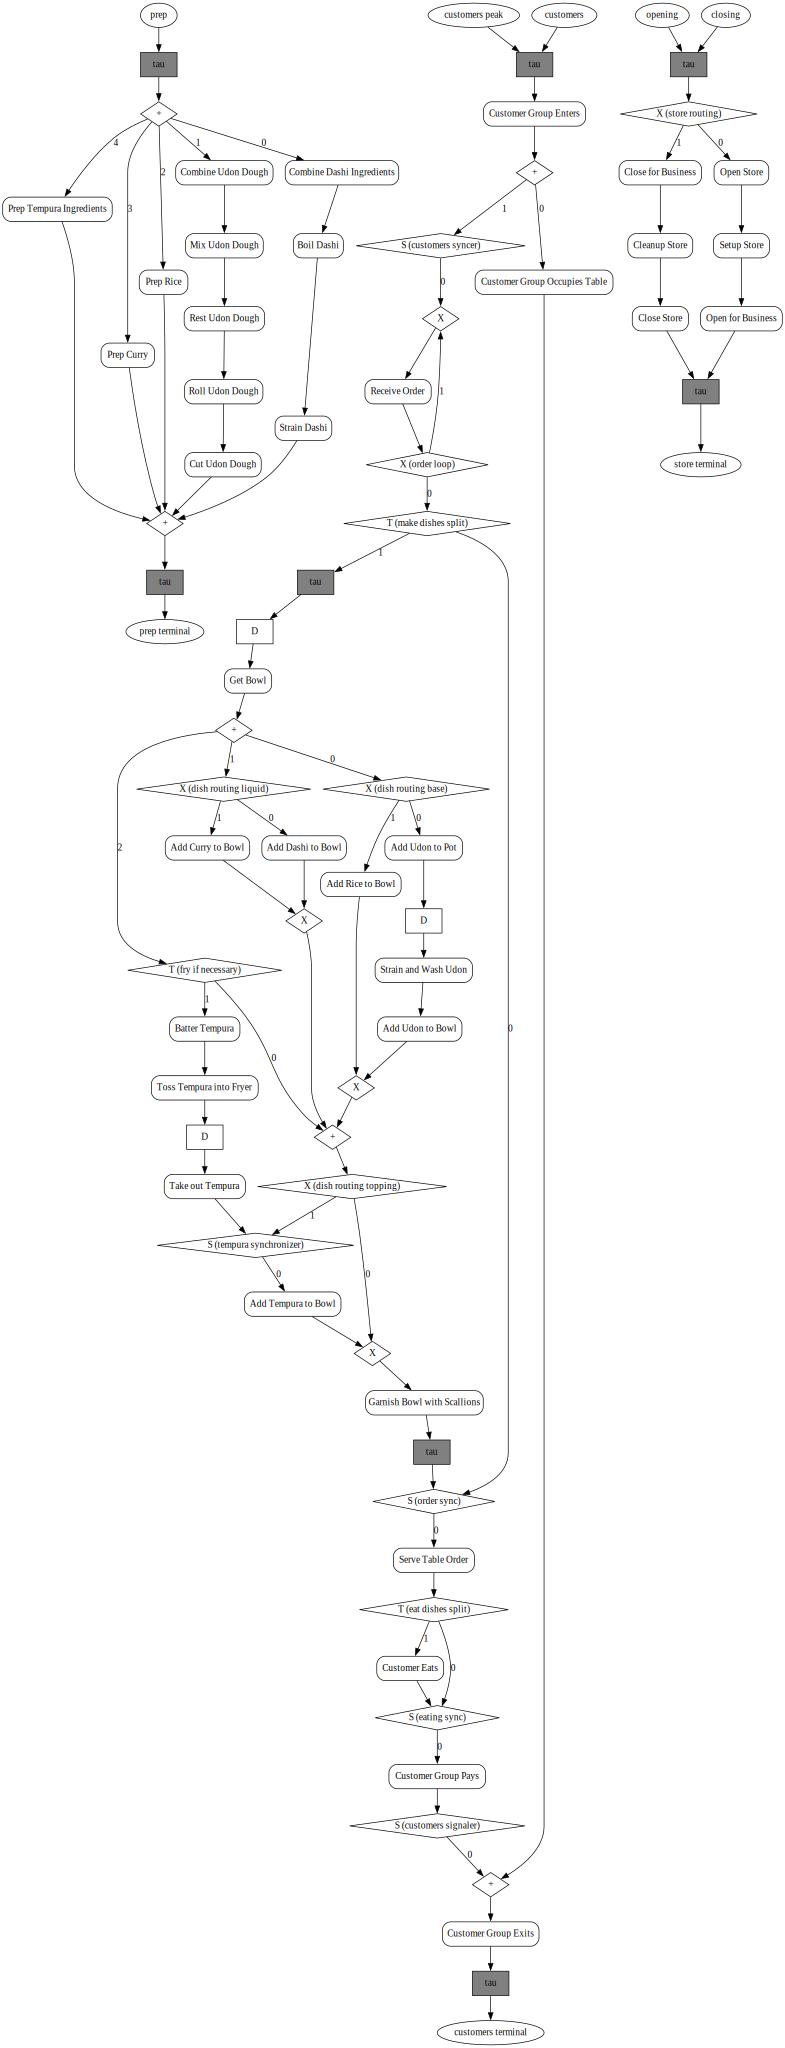

In [28]:
gv = visualize_sim_graph(sg, extended_node_labels=True, extended_edge_labels=True)
viz.save(gv, f'models/{log_name}')
gv

In [29]:
sg.aux_model_haver_map, cfg.aux_model_configs

({'Udon is Cooking': <qprsim.model.sim_graph.DelayNode at 0x25bd7c87a90>,
  'Tempura is Frying': <qprsim.model.sim_graph.DelayNode at 0x25bb1cc1c90>,
  'make dish callout': <qprsim.model.sim_graph.DelayNode at 0x25bb1d1bb90>,
  'fry if necessary': <qprsim.model.sim_graph.TransformationNode at 0x25bb1d1b690>,
  'tempura synchronizer': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1b58050>,
  'customers syncer': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d24150>,
  'customers signaler': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d23a10>,
  'make dishes split': <qprsim.model.sim_graph.TransformationNode at 0x25bb1d23b90>,
  'order sync': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d23cd0>,
  'eat dishes split': <qprsim.model.sim_graph.TransformationNode at 0x25bb1d23ed0>,
  'eating sync': <qprsim.model.sim_graph.SynchronizationNode at 0x25bb1d21e10>,
  'dish routing base': <qprsim.model.sim_graph.XorSplit at 0x25bb19ee710>,
  'dish routing liquid': <

In [30]:
cutoff = time_utils.add_relative_properly(generation_end, relativedelta(months=1))
sm = create_simulation_model(sg, cfg,
                             {ExecutionParameters.SimStartDate: process_start,
                              ExecutionParameters.GenerationCutoffDate: generation_end,
                              ExecutionParameters.SimCutoffDate: cutoff,
                              ExecutionParameters.RealtimeLimit: timedelta(
                                  minutes=10)})

In [31]:
what_if = ButWhatIf(sm)

In [32]:
arrival_change_1_start = datetime(2023, 6, 20, tzinfo=timezone)
# slowed customers arrival process and lowered group size
# removal of peak arrival process
arrival_change_1_end = datetime(2023, 7, 26, tzinfo=timezone)
# arrival processes back to initial setting

arrival_change_2_start = datetime(2023, 9, 1, tzinfo=timezone)
# customers arrival process faster and higher group size
# reinsertion of peak arrival process
arrival_change_2_end = datetime(2023, 10, 22, tzinfo=timezone)
# arrival processes back to initial setting

tenchou_sickness_start = datetime(2023, 10, 15, tzinfo=timezone)
# tenchou unavailable
tenchou_sickness_end = datetime(2023, 11, 5, tzinfo=timezone)
# tenchou available again

tables_reduced = datetime(2023, 11, 19, tzinfo=timezone)
tables_increased = datetime(2023, 12, 10, tzinfo=timezone)
tables_normal = datetime(2024, 1, 15, tzinfo=timezone)

what_if.schedule_arrival_process_swap(arrival_change_1_start, customers_arrival,
                                      ArrivalProcessConfig(arrival_change_1_start,
                                                           config.ExpSampler(15),
                                                           customers_arrival_bh,
                                                           attribute_generator=config.AttributeGeneratorUnion(
                                                               customers_id_gen,
                                                               config.StaticAttributeGenerator(
                                                                   customer_count=partial(
                                                                       np.random.randint,
                                                                       1, 2)))))
what_if.schedule_arrival_process_removal(arrival_change_1_start, customers_peak_arrival)
what_if.schedule_arrival_process_swap(arrival_change_1_end, customers_arrival, initial_customer_arrival_cfg)
what_if.schedule_arrival_process_insertion(arrival_change_1_end, customers_peak_arrival,
                                           initial_customer_peak_arrival_cfg)

what_if.schedule_arrival_process_swap(arrival_change_2_start, customers_arrival,
                                      ArrivalProcessConfig(arrival_change_2_start,
                                                           config.ExpSampler(13),
                                                           customers_arrival_bh,
                                                           attribute_generator=config.AttributeGeneratorUnion(
                                                               customers_id_gen,
                                                               config.StaticAttributeGenerator(
                                                                   customer_count=partial(
                                                                       np.random.randint,
                                                                       1, 5)))))
what_if.schedule_arrival_process_swap(arrival_change_2_start, customers_peak_arrival,
                                      ArrivalProcessConfig(arrival_change_2_start,
                                                           config.ExpSampler(5),
                                                           customers_peak_arrival_bh,
                                                           attribute_generator=config.AttributeGeneratorUnion(
                                                               customers_id_gen,
                                                               config.StaticAttributeGenerator(
                                                                   customer_count=partial(np.random.randint, 1,
                                                                                          3)))))

what_if.schedule_arrival_process_swap(arrival_change_2_end, customers_arrival, initial_customer_arrival_cfg)
what_if.schedule_arrival_process_swap(arrival_change_2_end, customers_peak_arrival, initial_customer_peak_arrival_cfg)

what_if.schedule_resource_business_hours_change(tenchou_sickness_start, tenchou, config.NeverInBusiness)
what_if.schedule_resource_business_hours_change(tenchou_sickness_end, tenchou, tenchou_hours)
#what_if.schedule_resource_property_change(tenchou_sickness_start, tenchou, enm.ResourceProperty.Capacity, 0)
#what_if.schedule_resource_property_change(tenchou_sickness_end, tenchou, enm.ResourceProperty.Capacity, 3)
what_if.schedule_resource_property_change(tables_reduced, tables, enm.ResourceProperty.Capacity, 8)
what_if.schedule_resource_property_change(tables_increased, tables, enm.ResourceProperty.Capacity, 24)
what_if.schedule_resource_property_change(tables_normal, tables, enm.ResourceProperty.Capacity, initial_table_count)
#what_if.schedule_resource_property_change(datetime(2023, 4, 20), baito, enm.ResourceProperty.Capacity, 0)
#what_if.schedule_resource_property_change(datetime(2023, 5, 20), baito, enm.ResourceProperty.Capacity, 2)

In [33]:
what_if.apply()

### Actual Simulation

In [35]:
simulator = simulate(sm, simulation_log_filename=f'logging/{log_name}.log')

### Defs

In [36]:
lifecycle_map_default = {a: enm.AvailableLifecycles.StartComplete for a in sg.activity_map}
lifecycle_map_default.update({customers_enter: enm.AvailableLifecycles.ScheduleStartComplete})
lifecycle_map_complete = {a: enm.AvailableLifecycles.CompleteOnly for a in sg.activity_map}

In [37]:
def create_lifecycle_filtered_log(cases, lifecycle_map):
    iterable = (c.filter(lambda e: e.activity in lifecycle_map and e.lifecycle in lifecycle_map[e.activity].vals) for c
                in cases)
    log = exporting.create_log(iterable)
    return log

In [38]:
def export(cases, name_extension='', lifecycle_map=lifecycle_map_default):
    log = create_lifecycle_filtered_log(cases, lifecycle_map)
    exporting.save_log(log, filename=f'logs/{log_name}/{name_extension}.xes')

In [39]:
def preview(cases, topn):
    for case in cases[:topn]:
        print(case.case_id, case.attributes)
        for e in case:
            if e.lifecycle in lifecycle_map_default[e.activity].vals:
                print('\t' + str(e))
        print()

### Necessary Transformations

In [40]:
sorted_cases = sorted(simulator.generated_cases, key=lambda c: c[0].timestamp)

In [41]:
for c in sorted_cases:
    for e in c:
        t = e.timestamp
        e.timestamp = datetime.combine(t.date(), time(hour=t.hour, minute=t.minute, second=t.second,
                                                      microsecond=round(t.microsecond, 2)))
        if 'duration' in e.attributes:
            dic = dict(e.attributes)
            dic['duration_in_s'] = dic['duration'].total_seconds()
            del dic['duration']
            e.attributes = dic

In [42]:
preview(sorted_cases, 3)

prep_0 {'case_type': 'prep'}
	Prep Tempura Ingredients[start] @2023-04-01 06:00 by Oku-san with {'duration_in_s': 7620.0}
	Combine Dashi Ingredients[start] @2023-04-01 06:00 by Tenchou-san with {'duration_in_s': 1080.0}
	Prep Rice[start] @2023-04-01 06:00 by Tenchou-san with {'duration_in_s': 1800.0}
	Combine Dashi Ingredients[complete] @2023-04-01 06:18 by Tenchou-san with {}
	Prep Curry[start] @2023-04-01 06:18 by Tenchou-san with {'duration_in_s': 3480.0}
	Boil Dashi[start] @2023-04-01 06:18 by Kitchen with {'duration_in_s': 5400.0}
	Prep Rice[complete] @2023-04-01 06:30 by Tenchou-san with {}
	Combine Udon Dough[start] @2023-04-01 06:30 by Tenchou-san with {'duration_in_s': 480.0}
	Combine Udon Dough[complete] @2023-04-01 06:38 by Tenchou-san with {}
	Mix Udon Dough[start] @2023-04-01 06:38 by Tenchou-san with {'duration_in_s': 600.0}
	Mix Udon Dough[complete] @2023-04-01 06:48 by Tenchou-san with {}
	Rest Udon Dough[start] @2023-04-01 06:48 by Kitchen with {'duration_in_s': 10800.

In [43]:
export(sorted_cases, 'full')

C:\Users\Leah\AppData\Local\pypoetry\Cache\virtualenvs\qprsim-neCHhO_m-py3.11\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


exporting log, completed traces ::   0%|          | 0/16481 [00:00<?, ?it/s]

In [44]:
# remove dish attribute
for c in sorted_cases:
    for e in c:
        if 'dish' in e.attributes:
            dic = dict(e.attributes)
            dic['dish'] = '?'
            e.attributes = dic

In [45]:
preview(sorted_cases, 3)

prep_0 {'case_type': 'prep'}
	Prep Tempura Ingredients[start] @2023-04-01 06:00 by Oku-san with {'duration_in_s': 7620.0}
	Combine Dashi Ingredients[start] @2023-04-01 06:00 by Tenchou-san with {'duration_in_s': 1080.0}
	Prep Rice[start] @2023-04-01 06:00 by Tenchou-san with {'duration_in_s': 1800.0}
	Combine Dashi Ingredients[complete] @2023-04-01 06:18 by Tenchou-san with {}
	Prep Curry[start] @2023-04-01 06:18 by Tenchou-san with {'duration_in_s': 3480.0}
	Boil Dashi[start] @2023-04-01 06:18 by Kitchen with {'duration_in_s': 5400.0}
	Prep Rice[complete] @2023-04-01 06:30 by Tenchou-san with {}
	Combine Udon Dough[start] @2023-04-01 06:30 by Tenchou-san with {'duration_in_s': 480.0}
	Combine Udon Dough[complete] @2023-04-01 06:38 by Tenchou-san with {}
	Mix Udon Dough[start] @2023-04-01 06:38 by Tenchou-san with {'duration_in_s': 600.0}
	Mix Udon Dough[complete] @2023-04-01 06:48 by Tenchou-san with {}
	Rest Udon Dough[start] @2023-04-01 06:48 by Kitchen with {'duration_in_s': 10800.

In [46]:
export(sorted_cases, 'udonya')

C:\Users\Leah\AppData\Local\pypoetry\Cache\virtualenvs\qprsim-neCHhO_m-py3.11\Lib\site-packages\pm4py\utils.py:486: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")


exporting log, completed traces ::   0%|          | 0/16481 [00:00<?, ?it/s]

In [47]:
prep_cases = [c for c in sorted_cases if c.get_case_attr_value('case_type') == 'prep']

In [48]:
export(prep_cases, 'ingredient_prep_A')

exporting log, completed traces ::   0%|          | 0/314 [00:00<?, ?it/s]

In [49]:
export(prep_cases, 'ingredient_prep_B', lifecycle_map=lifecycle_map_complete)

exporting log, completed traces ::   0%|          | 0/314 [00:00<?, ?it/s]

In [50]:
customers_cases = [c for c in sorted_cases if c.get_case_attr_value('case_type') == 'customers']

In [51]:
customer_perspective_activities = {customers_enter, customers_seated, rec_order, start_bowl, add_scallions, serve_order,
                                   customer_eats, customers_pay, customers_exit}

In [52]:
customer_perspective_cases = [c.filter(lambda e: e.activity in customer_perspective_activities) for c in
                              customers_cases]

In [53]:
export(customer_perspective_cases, 'customer_perspective')

exporting log, completed traces ::   0%|          | 0/14911 [00:00<?, ?it/s]

In [54]:
skip_scallions_prob = 0.05
skip_payment = 0.07


def cond_removal(e: sc.CaseEvent):
    if e.activity == add_scallions:
        return skip_scallions_prob < np.random.random_sample()
    elif e.activity == customers_pay:
        return skip_payment < np.random.random_sample()
    else:
        return True


customer_perspective_cases_dev = [c.filter(cond_removal) for c in customer_perspective_cases]

In [55]:
export(customer_perspective_cases_dev, 'customer_perspective_dev')

exporting log, completed traces ::   0%|          | 0/14911 [00:00<?, ?it/s]

In [56]:
dish_activities = {rec_order, start_bowl, udon_to_pot, strain_udon, add_udon, batter_tempura, toss_tempura,
                   take_out_tempura, add_tempura, add_rice, add_curry, add_dashi, add_scallions}

In [57]:
dish_cases = [c.filter(lambda e: e.activity in dish_activities) for c in customers_cases]

In [58]:
export(dish_cases, 'dish_cooking')

exporting log, completed traces ::   0%|          | 0/14911 [00:00<?, ?it/s]

### Sanity Checks

In [59]:
sg.aux_model_haver_map['order sync'].model.child_cases_left

defaultdict(int, {})

In [60]:
if sm.simulation_context.are_active_cases_remaining():
    for i, c in enumerate(sm.simulation_context.remaining_active_cases):
        if i > 10:
            break
        print(c.case_id)
        print(c.attributes)
        for ce in c:
            print(ce)

customers_45
{'case_type': 'customers', 'customer_group_id': 'regular_45', 'customer_count': 3}
customers_71
{'case_type': 'customers', 'customer_group_id': 'regular_71', 'customer_count': 3}
customers_72
{'case_type': 'customers', 'customer_group_id': 'regular_72', 'customer_count': 1}
customers_290
{'case_type': 'customers', 'customer_group_id': 'regular_290', 'customer_count': 3}
customers_667
{'case_type': 'customers', 'customer_group_id': 'regular_667', 'customer_count': 2}
customers_668
{'case_type': 'customers', 'customer_group_id': 'regular_668', 'customer_count': 1}
customers_669
{'case_type': 'customers', 'customer_group_id': 'regular_669', 'customer_count': 3}
customers_886
{'case_type': 'customers', 'customer_group_id': 'regular_886', 'customer_count': 1}
customers_1013
{'case_type': 'customers', 'customer_group_id': 'regular_1013', 'customer_count': 3}
customers_1014
{'case_type': 'customers', 'customer_group_id': 'regular_1014', 'customer_count': 1}
customers peak_587
{'c

In [61]:
sm.simulation_context.started_cases_count, sm.simulation_context.completed_cases_count, len(
    sm.simulation_context.remaining_active_cases)

(16566, 16481, 85)